# Constructing an LDA model with spaCy and Gensim

In [1]:
%%capture
!pip install spacy gensim pprint
!python -m spacy download en_core_web_sm
!pip install pyldavis wordcloud bokeh

Initial imports

In [2]:
import pandas as pd
import numpy as np 
from pprint import pprint

import gensim, spacy, logging, warnings
from gensim import corpora
import pyLDAvis

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

We start with importing our data set into a Pandas dataframe

In [3]:
# Import Dataset
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
df.head()

,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space


In [4]:
df.shape

(11314, 3)

In [5]:
df.drop(columns=["target"], inplace=True)
df = df.loc[df.target_names.isin(['soc.religion.christian', 'rec.sport.hockey', 'talk.politics.mideast', 'rec.motorcycles']) , :].reset_index()
print(df.shape)
df.head()

(2361, 3)


,index,content,target_names
0,10,From: irwin@cmptrc.lonestar.org (Irwin Arnstei...,rec.motorcycles
1,21,From: leunggm@odin.control.utoronto.ca (Gary L...,rec.sport.hockey
2,28,From: jonh@david.wheaton.edu (Jonathan Hayward...,soc.religion.christian
3,33,From: ayr1@cunixa.cc.columbia.edu (Amir Y Rose...,talk.politics.mideast
4,35,From: dchhabra@stpl.ists.ca (Deepak Chhabra)\n...,rec.sport.hockey


Before starting, we extend the stopword list of the English spaCy model with some domain-specific ones.

In [6]:
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

nlp.Defaults.stop_words.update(['from', 'subject', 're', 'edu', 'use', 'not', 
                               'would', 'say', 'could', '_', 'be', 'know', 'good', 
                               'go', 'get', 'do', 'done', 'try', 'many', 'some',
                               'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily',
                               'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even',
                               'right', 'line', 'even', 'also', 'may', 'take', 'come'])

First processing round: we tokenize, filter out non-alphabetic and too short or long tokens and lowercase.


In [7]:
%%time
MIN_WORD_LEN = 2
MAX_WORD_LEN = 15

def text_to_words(text):
    """Tokenize a text and do some prefiltering for n-gram processing.
    Please take the lowercased form of a token (after spacy analysis of text), 
    if it is not a number (consists of only letters), and it's character length is between the min and the max
    """
    ....
    
    return ....

texts = df.content.values.tolist()
texts_words = [text_to_words(text) for text in texts]
print(texts_words[:1])

[['from', 'irwin', 'arnstein', 'subject', 're', 'recommendation', 'on', 'duc', 'summary', 'what', 'it', 'worth', 'distribution', 'usa', 'expires', 'sat', 'may', 'gmt', 'organization', 'computrac', 'richardson', 'tx', 'keywords', 'ducati', 'gts', 'how', 'much', 'lines', 'have', 'line', 'on', 'ducati', 'model', 'with', 'on', 'the', 'clock', 'runs', 'very', 'well', 'paint', 'is', 'the', 'bronze', 'brown', 'orange', 'faded', 'out', 'leaks', 'bit', 'of', 'oil', 'and', 'pops', 'out', 'of', 'with', 'hard', 'accel', 'the', 'shop', 'will', 'fix', 'trans', 'and', 'oil', 'leak', 'they', 'sold', 'the', 'bike', 'to', 'the', 'and', 'only', 'owner', 'they', 'want', 'and', 'am', 'thinking', 'more', 'like', 'any', 'opinions', 'out', 'there', 'please', 'email', 'me', 'thanks', 'it', 'would', 'be', 'nice', 'stable', 'mate', 'to', 'the', 'beemer', 'then', 'get', 'jap', 'bike', 'and', 'call', 'myself', 'axis', 'motors', 'tuba', 'irwin', 'honk', 'therefore', 'am', 'computrac', 'richardson', 'tx', 'dod']]
CP

Merge bi-, tri- and four-gram collocations with Gensim

In [8]:
%%time
# Build the bigram and trigram models
# The minimum occurency of a bigram phrase should be 5
# Both the bigram and trigram phrases should have the threshold 100
bigram_phrases = .... #You should operate on text_phrases here
trigram_phrases = .... # You should use the previously defined bigram_phrases to "look up" text_phrases again

# This is a kind of technical pruning only.
bigram_phraser = gensim.models.phrases.Phraser(bigram_phrases)
trigram_phraser = gensim.models.phrases.Phraser(trigram_phrases)

CPU times: user 14.2 s, sys: 32 ms, total: 14.2 s
Wall time: 14.2 s


In [9]:
# Apply the n-gram models to the data
texts_words = [trigram_phraser[bigram_phraser[words]] for words in texts_words]

Having merged the collocations, we do another (final) round of filtering on the basis of stopwords and POS-tags, and lemmatize all tokens.

In [10]:
%%time
# Now we use spacy to filter based on stopwords, POS-tags and lemmatize

filtered_texts_lemmas = []

for words in texts_words:
    doc = spacy.tokens.Doc(nlp.vocab, words=words)
    tagged = nlp.get_pipe("tagger")(doc)
    
    # Please filter again, and keep only the lemma of tokens which are non stopwords and are either 'NOUN', 'ADJ', 'VERB' or 'ADV
    # with regards to their part of speech tags
    lemmas = .... # you can do  this with a list comprehension or a for cycle, up to you
    filtered_texts_lemmas.append(lemmas)

print(filtered_texts_lemmas[0])

['recommendation', 'duc', 'summary', 'worth', 'expire', 'gmt', 'ducati', 'line', 'ducati', 'model', 'clock', 'run', 'paint', 'bronze', 'orange', 'fade', 'leak', 'bit', 'oil', 'pop', 'hard', 'accel', 'shop', 'fix', 'tran', 'oil', 'leak', 'sell', 'bike', 'owner', 'think', 'opinion', 'email', 'thank', 'stable', 'mate', 'beemer', 'bike', 'motor', 'computrac_richardson_tx']
CPU times: user 36.1 s, sys: 7.97 ms, total: 36.1 s
Wall time: 27.4 s


Time to build the LDA model!

In [11]:
%%capture
# Create Dictionary
id2word = .... #create a Gensim dictionary from the final "filtered_texts_lemmas"

id2word.... # use a function of the dictionary to filter out the "extremes", meaning: keep only 5000 elements.

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(words) for words in filtered_texts_lemmas]

# Build LDA model with the corpus, the dictionary mapping and 4 topics! (All other parameters we have given...)
lda_model = gensim.models.ldamodel.LdaModel(...., 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=20,
                                           alpha='auto',
                                           iterations=400,
                                           per_word_topics=True)

In [12]:
pprint(lda_model.print_topics())

[(0,
  '0.012*"people" + 0.010*"israeli" + 0.009*"state" + 0.006*"law" + '
  '0.006*"government" + 0.006*"jewish" + 0.005*"war" + 0.005*"turkish" + '
  '0.005*"attack" + 0.005*"armenian"'),
 (1,
  '0.024*"team" + 0.020*"game" + 0.013*"play" + 0.012*"year" + 0.012*"player" '
  '+ 0.009*"win" + 0.009*"hockey" + 0.007*"organization" + 0.007*"time" + '
  '0.007*"season"'),
 (2,
  '0.013*"believe" + 0.013*"people" + 0.010*"question" + 0.008*"thing" + '
  '0.008*"reason" + 0.008*"church" + 0.007*"say" + 0.007*"faith" + '
  '0.007*"mean" + 0.006*"time"'),
 (3,
  '0.017*"go" + 0.016*"say" + 0.015*"bike" + 0.009*"time" + 0.009*"tell" + '
  '0.008*"ride" + 0.008*"people" + 0.007*"get" + 0.007*"look" + 0.007*"see"')]


# Inference and visualizations

### Dominant topic and its percentage in documents

In [13]:
texts_topics_df = pd.DataFrame()

# Get main topic in each document
for topic_probs, text in zip(lda_model.get_document_topics(corpus), filtered_texts_lemmas):
    topic_num, topic_prob = max(topic_probs, key=lambda x: x[1])
    wp = lda_model.show_topic(topic_num)
    topic_keywords = ", ".join([word for word, _ in wp])
    texts_topics_df = texts_topics_df.append(pd.Series([topic_num, round(topic_prob,4), topic_keywords, text]), ignore_index=True)

texts_topics_df.columns = ["topic_no", "topic_ratio", "keywords", "text"]
texts_topics_df["topic_no"]=texts_topics_df.topic_no.astype("int")
texts_topics_df.head(10)

,topic_no,topic_ratio,keywords,text
0,1,0.6725,"team, game, play, year, player, win, hockey, o...","[recommendation, duc, summary, worth, expire, ..."
1,1,0.8181,"team, game, play, year, player, win, hockey, o...","[group, line, article, write, course, time, ca..."
2,2,0.7073,"believe, people, question, thing, reason, chur...","[article, write, new, group, maybe, cover, cur..."
3,0,0.6796,"people, israeli, state, law, government, jewis...","[nntp_posting_host, reply, amir_rosenblatt, or..."
4,1,0.7660,"team, game, play, year, player, win, hockey, o...","[goalie_mask, organization, solar_terresterial..."
5,1,0.5396,"team, game, play, year, player, win, hockey, o...","[bmw_moa_member, read, organization, national,..."
6,1,0.5880,"team, game, play, year, player, win, hockey, o...","[should_liability_insurance, require, organiza..."
7,1,0.5377,"team, game, play, year, player, win, hockey, o...","[look, movie, university, line, summary, bike,..."
8,2,0.7364,"believe, people, question, thing, reason, chur...","[university, line, follow, thread, study, inte..."
9,0,0.8026,"people, israeli, state, law, government, jewis...","[uucp_serdar_argic, day, night, round, male, i..."


### Wordcloud of the most important keywords in each topic

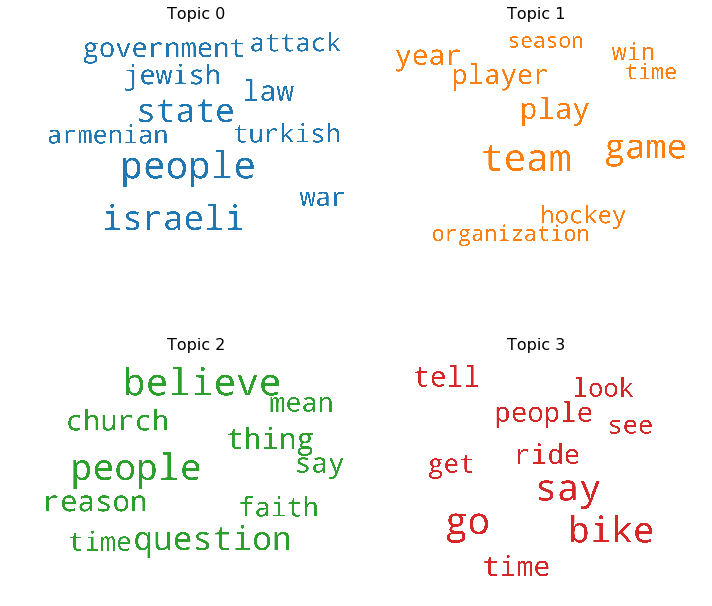

In [14]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=nlp.Defaults.stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False, num_words=10)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

**Important:**

Please bear in mind, that topics can come up in random order, so a mapping between the original labels and LDA's topic numbers is non-trivial! **You have to observe the topics, and try to come up with a mapping / interpretation of them!!** 

(Naturally, in a "normal", unlabeled dataset this in itself is a question, since you do not know the topics upfront.)

In [ ]:
# Assign numbers to the topics!

topic_to_label_mapping={
                        "rec.motorcycles": ...., 
                        "talk.politics.mideast": ...., 
                        "soc.religion.christian": ...., 
                        "rec.sport.hockey": ....
                        }

.... #Just put this line here to halt the notebook, so you don't skip this. Remove if done! 

### Sentence and word coloring by topic

Please observe the results!

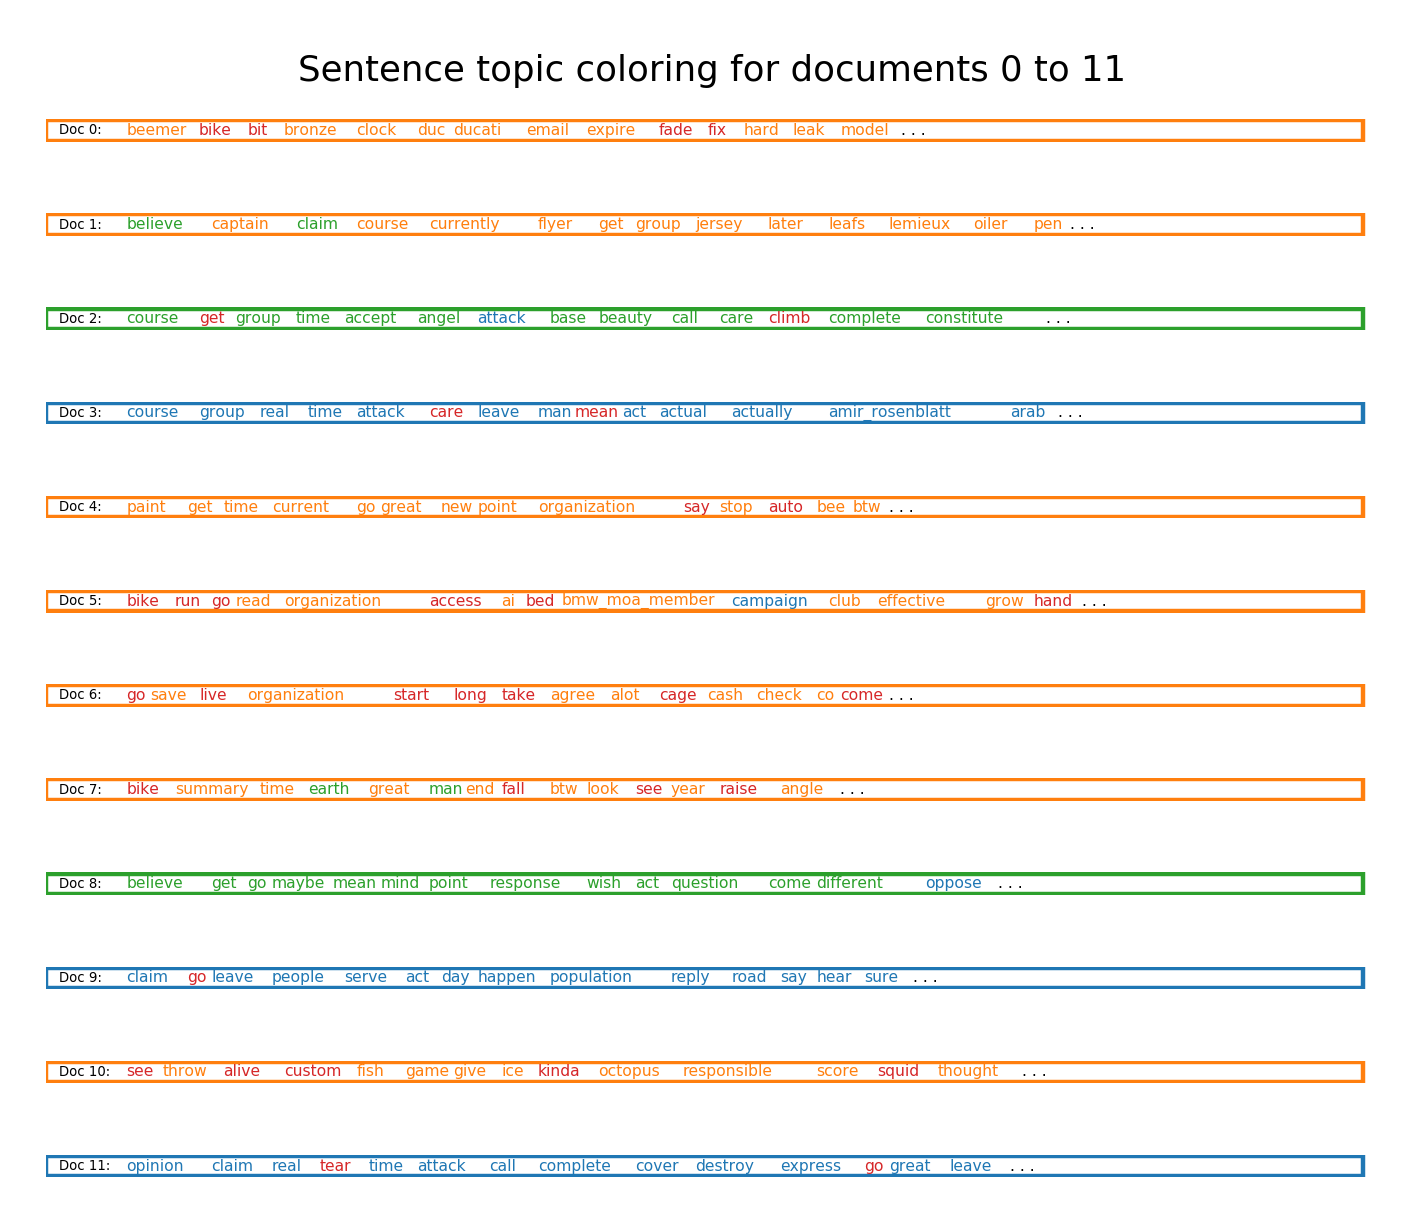

In [15]:
# Sentence Coloring of N Sentences
# For simplicity
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for _, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(9, (end-start)*0.6), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model.get_document_topics(corp_cur, per_word_topics=True)
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=6, color='black', transform=ax.transAxes, fontweight=300)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.98, 0.9, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=7, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=300)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=7, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence topic coloring for documents ' + str(start) + ' to ' + str(end-2), fontsize=16, y=0.95, fontweight=300)
    plt.tight_layout()
    plt.show()

sentences_chart()    

### t-SNE visualisation of the documents


In [16]:
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

topic_probs = []

# Get the topic probabilities for the whole corpus from the model
for probs in lda_model.get_document_topics(corpus, minimum_probability=-1): # minimum_probability=-1 to always get all probs
    topic_probs.append([prob for _, prob in probs])

# Topic probs df
df_topic_probs = pd.DataFrame(topic_probs, columns=["topic_0_prob", "topic_1_prob", "topic_2_prob", "topic_3_prob"])

# Topic weights NumPy array
arr = df_topic_probs.values

# Keep the well separated points (optional)
# arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# Fit a tSNE model
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot);

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2361 samples in 0.007s...
[t-SNE] Computed neighbors for 2361 samples in 0.069s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2361
[t-SNE] Computed conditional probabilities for sample 2000 / 2361
[t-SNE] Computed conditional probabilities for sample 2361 / 2361
[t-SNE] Mean sigma: 0.032811
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.133514
[t-SNE] KL divergence after 1000 iterations: 0.663872


Loading BokehJS ...

### pyLDAvis
pyLDAvis is a nice off-the-shelve solution for visualising the found topics and keywords.

In [17]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
# Warning: "prepare" can take up to 5 minutes!
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word, mds='mmds')
vis

/home/alatus/anaconda3/envs/nlp_course/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.223533  0.110221       1        1  29.074696
2      0.126543 -0.227651       2        1  26.911486
3     -0.237216 -0.116504       3        1  22.736830
1     -0.112859  0.233935       4        1  21.276993, topic_info=    Category         Freq     Term        Total  loglift  logprob
945  Default  1066.000000     team  1066.000000  30.0000  30.0000
524  Default   888.000000     game   888.000000  29.0000  29.0000
1    Default   730.000000     bike   730.000000  28.0000  28.0000
45   Default   609.000000     play   609.000000  27.0000  27.0000
30   Default   805.000000  believe   805.000000  26.0000  26.0000
..       ...          ...      ...          ...      ...      ...
240   Topic4   176.695206     good   304.128082   1.0045  -5.5429
85    Topic4   237.690918       go  1182.815552  -0.0571  -5.2463
112   Topic4   188.895752     post   438.055481   0.7064  -5.4761
86    Topic4   183.998703    great   411.517334   0.7426  -5.5024
105   Topic4   175.452835      new   460.154724   0.5834  -5.5499

[256 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
2643      2  0.994324  absolute
1556      1  0.960136    action
1556      4  0.039769    action
1047      3  0.986075    advice
2782      3  0.982397    afraid
...     ...       ...       ...
378       2  0.318772     world
378       4  0.106894     world
255       1  0.293441      year
255       3  0.122180      year
255       4  0.584794      year

[368 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 4, 2])

# The LDA model as a classifier

## Using simply the dominant topic as predicted class

First we extend our original dataframe with our "predictions" (the dominant topic) and the ground truth.

In [26]:
df["group_id"] = df.target_names.map(topic_to_label_mapping)
df["group_id_predicted"] = texts_topics_df.topic_no
df.head()

,index,content,target_names,group_id,group_id_predicted,topic_0_prob,topic_1_prob,topic_2_prob,topic_3_prob
0,10,From: irwin@cmptrc.lonestar.org (Irwin Arnstei...,rec.motorcycles,3,1,0.011843,0.672534,0.015680,0.299943
1,21,From: leunggm@odin.control.utoronto.ca (Gary L...,rec.sport.hockey,1,1,0.010380,0.818112,0.096410,0.075098
2,28,From: jonh@david.wheaton.edu (Jonathan Hayward...,soc.religion.christian,2,2,0.101754,0.006096,0.707328,0.184821
3,33,From: ayr1@cunixa.cc.columbia.edu (Amir Y Rose...,talk.politics.mideast,0,0,0.679602,0.018601,0.036611,0.265186
4,35,From: dchhabra@stpl.ists.ca (Deepak Chhabra)\n...,rec.sport.hockey,1,1,0.008994,0.765950,0.011123,0.213933


Let's see how well we are doing...

In [27]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(df.group_id, df.group_id_predicted))

              precision    recall  f1-score   support

           0       0.89      0.81      0.85       564
           1       0.79      0.98      0.87       600
           2       0.88      0.86      0.87       599
           3       0.83      0.72      0.77       598

    accuracy                           0.84      2361
   macro avg       0.85      0.84      0.84      2361
weighted avg       0.85      0.84      0.84      2361



## Using topic probabilities for training a linear classifier

The topic probability distributions for documents provided by an LDA model can be useful feature vectors for document classification, e.g., for sentiment analysis. To illustrate this, we train an SVM classifier to predict the original topic of documents based on the LDA topic probabilities. First we add the whole topic distribution to our df.

In [28]:
df = pd.concat([df, df_topic_probs], axis = 1)
df.head()

,index,content,target_names,group_id,group_id_predicted,topic_0_prob,topic_1_prob,topic_2_prob,topic_3_prob,topic_0_prob,topic_1_prob,topic_2_prob,topic_3_prob
0,10,From: irwin@cmptrc.lonestar.org (Irwin Arnstei...,rec.motorcycles,3,1,0.011843,0.672534,0.015680,0.299943,0.011843,0.672534,0.015680,0.299943
1,21,From: leunggm@odin.control.utoronto.ca (Gary L...,rec.sport.hockey,1,1,0.010380,0.818112,0.096410,0.075098,0.010380,0.818112,0.096410,0.075098
2,28,From: jonh@david.wheaton.edu (Jonathan Hayward...,soc.religion.christian,2,2,0.101754,0.006096,0.707328,0.184821,0.101754,0.006096,0.707328,0.184821
3,33,From: ayr1@cunixa.cc.columbia.edu (Amir Y Rose...,talk.politics.mideast,0,0,0.679602,0.018601,0.036611,0.265186,0.679602,0.018601,0.036611,0.265186
4,35,From: dchhabra@stpl.ists.ca (Deepak Chhabra)\n...,rec.sport.hockey,1,1,0.008994,0.765950,0.011123,0.213933,0.008994,0.765950,0.011123,0.213933


We do a train-test split:


In [29]:
from sklearn.model_selection import train_test_split
df_train, df_valid = train_test_split(df, test_size=0.1)
print("df_train len:", len(df_train))
print("df_valid len:", len(df_valid))

df_train len: 2124
df_valid len: 237


And train an SVM classifier on the data

In [30]:
from sklearn.svm import SVC

svc = SVC(kernel="linear")

svc.fit(df_train[["topic_0_prob", "topic_1_prob", "topic_2_prob", "topic_3_prob"]], df_train.group_id)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [31]:
valid_predictions = svc.predict(df_valid[["topic_0_prob", "topic_1_prob", "topic_2_prob", "topic_3_prob"]])

print(classification_report(df_valid.group_id, valid_predictions))

              precision    recall  f1-score   support

           0       0.94      0.83      0.88        60
           1       0.88      0.97      0.92        66
           2       0.81      0.90      0.85        42
           3       0.91      0.84      0.87        69

    accuracy                           0.89       237
   macro avg       0.88      0.89      0.88       237
weighted avg       0.89      0.89      0.89       237



Looking at the results we can see that we gained 6% accuracy by switching from using simply the dominant topic to an SVM classifier trained explicitly on the original topic/newsgroup labels.